# Quantile Regression

Based on [Quantile Regression - EXPLAINED!](https://www.youtube.com/watch?v=JvIzB3hULCo) from [CodeEmporium](https://www.youtube.com/channel/UC5_6ZD6s8klmMu9TXEB_1IA) Youtube channel

In [1]:
# !pip3 install lightgbm

## Example of Quantile Loss

Let us build a regression model that determines delivery time based on distance of house from store. 

## Build Dataset

In [2]:
from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [3]:
X, y = make_regression(n_samples=10000,
                      n_features=1,
                      n_informative=1,
                      n_targets=1,
                      random_state=42)

In [4]:
Xs = pd.DataFrame(X, columns=['distance'])
ys = pd.DataFrame(y, columns=['time_to_buyer'])

In [5]:
Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1)))
ys['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x: 60 + 0.3 * (x + np.random.normal(loc=1)))

In [6]:
df = Xs.merge(ys, left_index=True, right_index=True)

In [7]:
df.describe()

,distance,time_to_buyer
count,10000.000000,10000.000000
mean,11.985761,60.276704
std,2.813903,9.675057
min,0.935492,22.348641
25%,10.103246,53.809752
50%,11.983738,60.306432
75%,13.879125,66.756260
max,22.475272,97.901275


In [8]:
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)

In [9]:
X_train, y_train = train_df[['distance']], train_df[['time_to_buyer']]
X_test, y_test = test_df[['distance']], test_df[['time_to_buyer']]

## Visualize Data

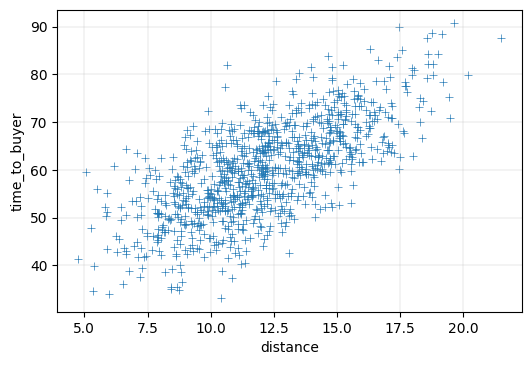

In [10]:
plt.rcParams.update({'font.size':10, 'figure.dpi':100})
sns.scatterplot(data=test_df, x="distance", y="time_to_buyer", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [11]:
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns=[str(tau)])
    classifiers[str(tau)] = {'clf':clf, 'predictions':preds}

In [12]:
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
                    '0.1': classifiers['0.1']['predictions']['0.1'],
                    '0.5': classifiers['0.5']['predictions']['0.5'],
                    '0.9': classifiers['0.9']['predictions']['0.9'],
                    'time_to_buyer':y_test.reset_index()['time_to_buyer']})

In [13]:
data.sample(2)

,distance,0.1,0.5,0.9,time_to_buyer
490,12.080154,52.909358,61.813398,71.249210,59.192006
190,15.594245,61.370803,68.757364,76.733809,62.369729


In [14]:
melted_data = pd.melt(data, id_vars=['distance'])

In [15]:
melted_data

,distance,variable,value
0,10.310078,0.1,46.299349
1,10.538768,0.1,48.008126
2,12.751703,0.1,55.596725
3,5.509549,0.1,33.176168
4,9.394889,0.1,46.123508
...,...,...,...
3995,16.003736,time_to_buyer,61.736627
3996,17.449258,time_to_buyer,60.288512
3997,14.016585,time_to_buyer,76.118326
3998,8.019516,time_to_buyer,53.391619


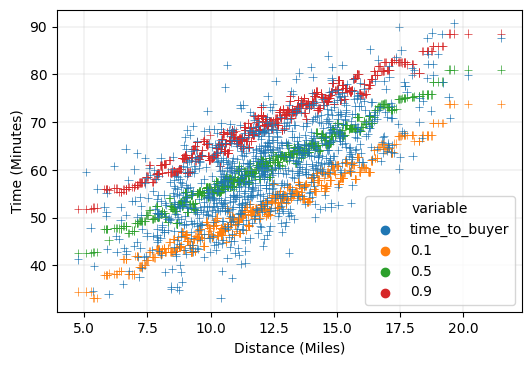

In [16]:
plt.rcParams.update({'font.size':10, 'figure.dpi':100})
sns.scatterplot(data=melted_data,
                x="distance",
                y="value",
                hue="variable",
                hue_order=['time_to_buyer', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")

In [17]:
(data['time_to_buyer'] > data['0.1']).value_counts()

True     876
False    124
dtype: int64

In [18]:
(data['time_to_buyer'] > data['0.5']).value_counts()

False    530
True     470
dtype: int64

In [19]:
(data['time_to_buyer'] > data['0.9']).value_counts()

False    898
True     102
dtype: int64

## Notes

* Instacart: https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb
* Quantile Regression Blog http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html